In [ ]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense#, Dropout, Flatten
#from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import glob
import pylab as pl
from PIL import Image

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# 1. change kernel to GPU 
go to runtime -> change runtime type -> GPU

# digits first

(60000, 28, 28)

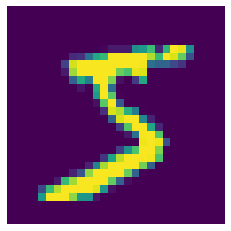

In [ ]:
# from keras.datasets import mnist
(x_train, _), (x_test, _) = mnist.load_data() # _ per i dati che non interessano
# la y corrisponderebbe al numero nell'immagine, ma in questo caso non interessa

img_rows, img_cols = 28, 28
pl.imshow(x_train[0])
pl.axis('off')
intialshape = x_train[0].shape
ndim = np.prod(x_train[0].shape) # prodotto dei pixel sulle righe e sulle colonne
x_train.shape

In [ ]:
x_train.dtype, x_train.max(), x_train.min()


(dtype('uint8'), 255, 0)

In [ ]:
# si trasforma l'img in una riga di pixel perchè non si vuole utilizzare una rete convoluzionale
x_train = (x_train.astype(float) / 255).reshape(len(x_train), ndim)
x_test = (x_test.astype(float) / 255).reshape(len(x_test), ndim)
x_train.shape, x_test.shape

((60000, 784), (10000, 784))

# create a model

In [ ]:
keras.models?

loss collegata al'activation function dell'ultimo layer

mean squared error valuta la distanza del colore dei pixel da quello previsto in una scala dal bianco al nero e l'activation più adatta è la linear

In [ ]:
model_digits64 = Sequential() # feedforward
# non devono per forza essere tutti dense layer ma è il modo più semplice
## encoder
# input layer and the output size
model_digits64.add(Dense(units = 128, activation = 'relu', input_dim = ndim))
# il numero di neuroni in potenze di due è computazionalmente più efficiente
# compression layer
model_digits64.add(Dense(units = 64, activation = 'relu'))
## deencoder
#decompression layer, same size as in the encoder
model_digits64.add(Dense(units = 128, activation = 'relu'))
#output layer, same size as input
model_digits64.add(Dense(ndim, activation='linear'))
# linear --> mantiene troppi dettagli in un'immagine che invece è prevalentemente bianca e nera
# tutti i valori hanno la stessa probabilità, mentre il sigmoid comprime i valori

#alternative syntax
"""
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

autoencoder = Model(input_img, decoded)

encoder = Model(input_img, encoded)

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))
"""

'\nencoded = Dense(encoding_dim, activation=\'relu\')(input_img)\n# "decoded" is the lossy reconstruction of the input\ndecoded = Dense(784, activation=\'sigmoid\')(encoded)\n\nautoencoder = Model(input_img, decoded)\n\nencoder = Model(input_img, encoded)\n\n# create a placeholder for an encoded (32-dimensional) input\nencoded_input = Input(shape=(encoding_dim,))\n# retrieve the last layer of the autoencoder model\ndecoder_layer = autoencoder.layers[-1]\n# create the decoder model\ndecoder = Model(encoded_input, decoder_layer(encoded_input))\n'

### regression
- loss='mean_squared_error' L2: default loss to use for regression problems. => linear activation function in output layer, one node out

alternatives:  loss='mean_squared_logarithmic_error', 'mean_absolute_error' (which is L1 instead of L2)
### binary classification

- loss='binary_crossentropy' => sigmoid activation function in output layer, one node out

alternatives: 'hinge'

### multiclass classification
categorical encoded as numerical
- loss='categorical_crossentropy' => softmax n nodes out

onehot encoded categoridal
- 'parse_categorical_crossentropy' => softmax n nodes out

- 'kullback Leibler Divergence Loss' => probabilistic categorical classification; log(P/Q)

## optimizers
- SGD: stocastic gradient descent 
    - nesterov=True -> momentum inclusion
- adam: Adaptive moment estimation. **good in most cases**
- adagrad: different steps for different parameters based on frequency (binary input) well-suited for dealing with sparse data.

- adaDelta: like adagrad but compensated for vanishing learning rate problem

momentum refers to looking one step back and make a decision that includes the slope there

### parameter:
generally you need to adjust the learning rate which is how much you change the parameters by at each step. 
keras.optimizers.Adam(lr=0.001)


https://gitcdn.xyz/cdn/Tony607/blog_statics/e1a0b1e060e783bd1978a141acff897ae71bd021/images/optimizer/optimizer.gif

In [ ]:
# choose the optimizer and loss appropriately!
model_digits64.compile(keras.optimizers.Adam(lr=0.001), loss = 'mean_squared_error') # regression

In [ ]:
print(model_digits64.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 784)               101136    
Total params: 218,192
Trainable params: 218,192
Non-trainable params: 0
_________________________________________________________________
None


https://keras.io/api/models/model_training_apis/

**batch_size**: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32.

**verbose**: 0, 1, or 2. Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.

**validation_data**: Data on which to evaluate the loss and any model metrics at the end of each epoch. The model will not be trained on this data.

In [ ]:
history64 = model_digits64.fit(x_train, x_train, # target = input
                               validation_data=(x_test, x_test),
                               epochs=20, batch_size=100, verbose=1)
# batch size indica quante immagini si considerano alla volta 
# riduce l'overfitting ma se è troppo piccolo rallenta il training
# si può impostare per 200 epoche e utilizzare una funzione callback di tensorflow che si chiama 'patience' che ferma il processo quando la rete smette di imparare

Epoch 1/20
600/600 [==============================] - 2s 3ms/step - loss: 0.0431 - val_loss: 0.0175
Epoch 2/20
600/600 [==============================] - 1s 2ms/step - loss: 0.0174 - val_loss: 0.0160
Epoch 3/20
600/600 [==============================] - 1s 2ms/step - loss: 0.0161 - val_loss: 0.0150
Epoch 4/20
600/600 [==============================] - 1s 2ms/step - loss: 0.0151 - val_loss: 0.0146
Epoch 5/20
600/600 [==============================] - 1s 2ms/step - loss: 0.0149 - val_loss: 0.0144
Epoch 6/20
600/600 [==============================] - 1s 2ms/step - loss: 0.0147 - val_loss: 0.0143
Epoch 7/20
600/600 [==============================] - 1s 2ms/step - loss: 0.0145 - val_loss: 0.0140
Epoch 8/20
600/600 [==============================] - 1s 2ms/step - loss: 0.0144 - val_loss: 0.0140
Epoch 9/20
600/600 [==============================] - 1s 2ms/step - loss: 0.0143 - val_loss: 0.0139
Epoch 10/20
600/600 [==============================] - 1s 2ms/step - loss: 0.0141 - val_loss: 0.0137

# always look at the loss!

Text(0.5, 0, 'iteration')

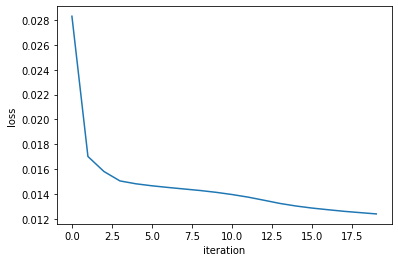

In [ ]:
pl.plot(np.array(history64.history['loss']))
pl.ylabel('loss')
pl.xlabel('iteration')
#pl.yscale('log')
#pl.xscale('log')

The loss fuctionis plotted and because it is still decreasingn quite rapidly (slope of the curve not near 0 yet) I know I did not run enough epochs. Try and run for 200 epochs!

# predict

In [ ]:
output_image64 = model_digits64.predict(x_test)

In [ ]:
def compareinout(i, outim, testimg, initialshape=(28,28)):
  fig = pl.figure(figsize(10,5))
  ax = fig.add_subplot(121) 
  ax.imshow(testimg[i].reshape(initialshape) , cmap="bone")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax = fig.add_subplot(122) 
  ax.imshow(outim[i].reshape(initialshape) , cmap="bone")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)


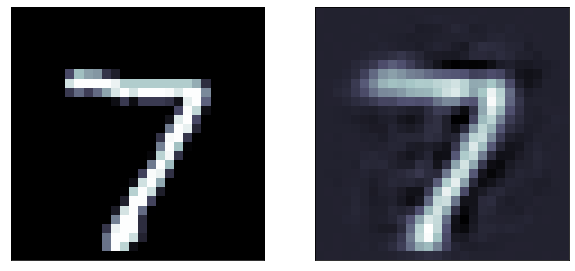

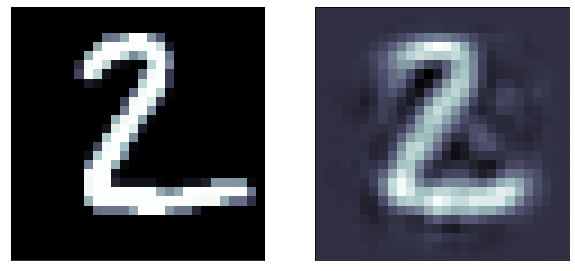

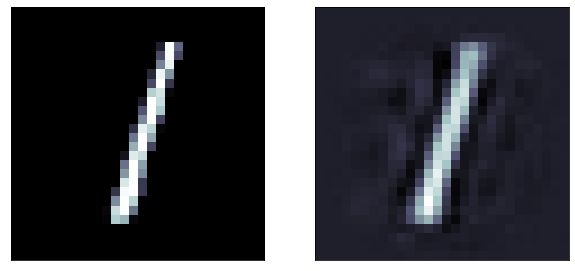

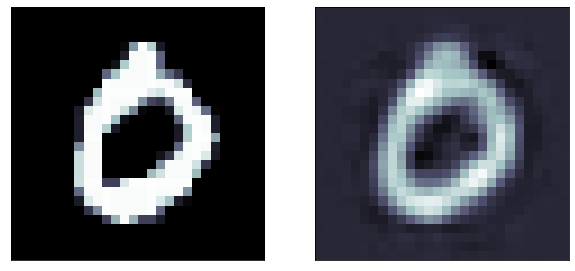

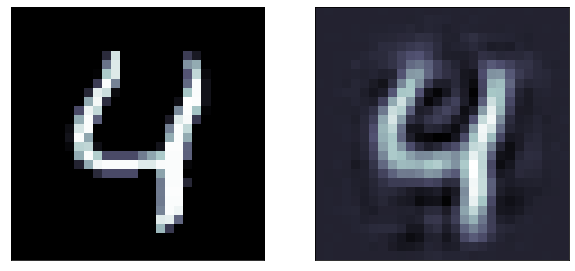

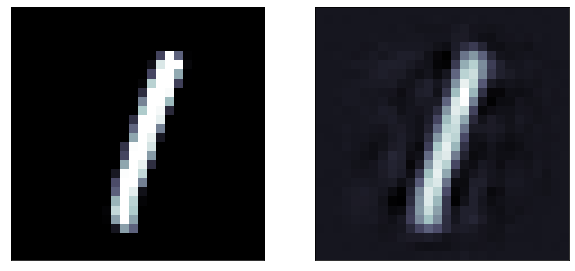

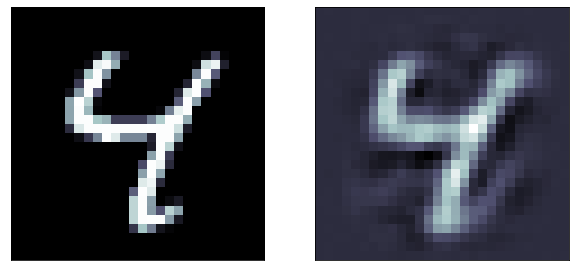

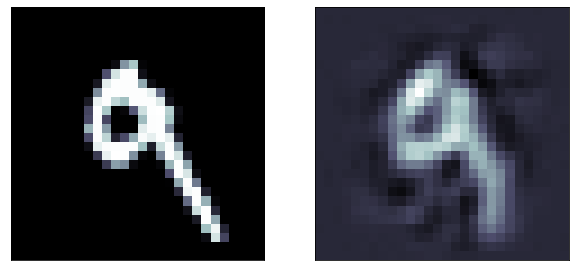

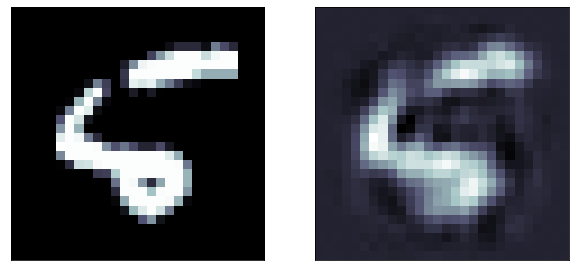

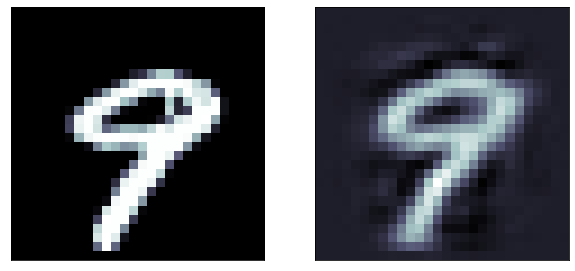

In [ ]:
for i in range(10):
  compareinout(i, output_image64, x_test)

This is a rather bad result. Let me see if I can improve it . The images are too detailed. I can treat the problem as a binary problem to derice some detail. To approach a binary classifier I switch the activation function in the last layer to sigmoid

# change loss function

Le immagini sono quasi-binarie e la linear activation function mantiene più dettagli dell'immagine di quelli di cui effettivamente si ha bisogno

La maggior parte dei pixel sono neri o bianchi --> sigmoid activation function

Immagini a colori normalizzate tra 0 e 1 sono invece più adatte alla linear

--> la loss e l'activation dell'ultimo layer sono cruciali per la buona riuscita della rete neurale

Scelta appropriata per il problema specifico

In [ ]:
# choose the optimizer and loss appropriately!
model_digits64_sig = Sequential()
## encoder
# input layer and the output size
model_digits64_sig.add(Dense(units = 128, activation = 'relu', input_dim = 784))
  #compression layer
model_digits64_sig.add(Dense(units = 64, activation = 'relu'))
## deencoder
#decompression layer, same size as in the encoder
model_digits64_sig.add(Dense(units = 128, activation = 'relu'))
#output layer, same size as input
model_digits64_sig.add(Dense(784, activation='sigmoid'))
model_digits64_sig.compile(keras.optimizers.Adam(lr=0.001), loss='mean_squared_error')
# ogni pixel viene predetto come 0 o 1 a seconda della soglia a 0.5

In [ ]:
history64_sig = model_digits64_sig.fit(x_train, x_train, 
                                       validation_data=(x_test, x_test), 
                                       epochs=20, batch_size=100, verbose=1)

Epoch 1/20
600/600 [==============================] - 2s 3ms/step - loss: 0.0644 - val_loss: 0.0166
Epoch 2/20
600/600 [==============================] - 1s 2ms/step - loss: 0.0155 - val_loss: 0.0118
Epoch 3/20
600/600 [==============================] - 1s 2ms/step - loss: 0.0114 - val_loss: 0.0096
Epoch 4/20
600/600 [==============================] - 1s 2ms/step - loss: 0.0096 - val_loss: 0.0085
Epoch 5/20
600/600 [==============================] - 1s 2ms/step - loss: 0.0085 - val_loss: 0.0076
Epoch 6/20
600/600 [==============================] - 1s 2ms/step - loss: 0.0076 - val_loss: 0.0068
Epoch 7/20
600/600 [==============================] - 1s 2ms/step - loss: 0.0070 - val_loss: 0.0064
Epoch 8/20
600/600 [==============================] - 1s 2ms/step - loss: 0.0065 - val_loss: 0.0061
Epoch 9/20
600/600 [==============================] - 1s 2ms/step - loss: 0.0062 - val_loss: 0.0058
Epoch 10/20
600/600 [==============================] - 1s 2ms/step - loss: 0.0059 - val_loss: 0.0056

Text(0.5, 0, 'iteration')

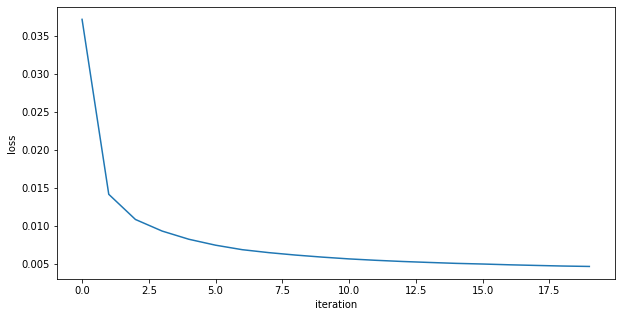

In [ ]:
pl.plot(np.array(history64_sig.history['loss']))
pl.ylabel('loss')
pl.xlabel('iteration')
#pl.yscale('log')
#pl.xscale('log')

The loss fuctionis plotted and because it is still decreasingn quite rapidly (slope of the curve not near 0 yet) I know I did not run enough epochs. Try and run for 200 epochs!

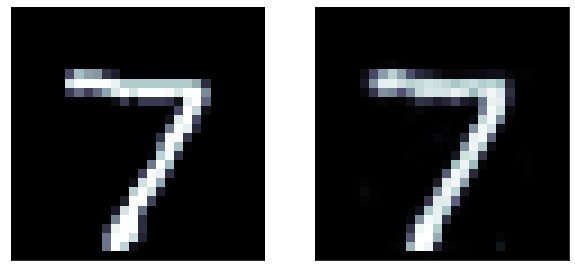

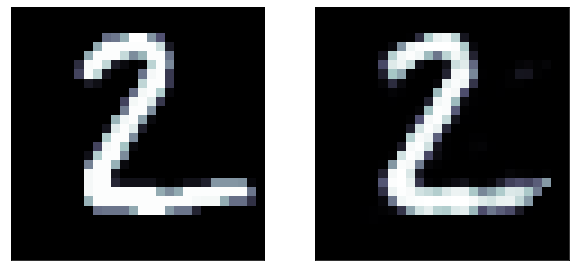

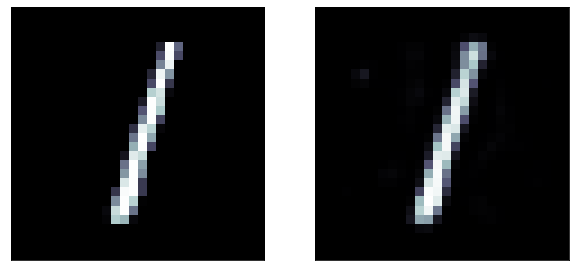

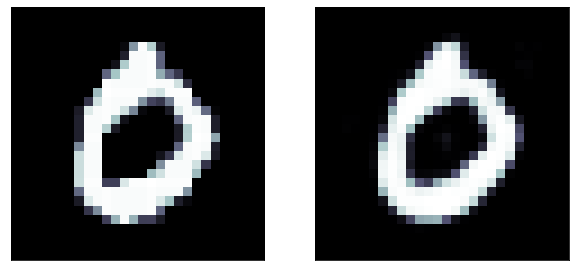

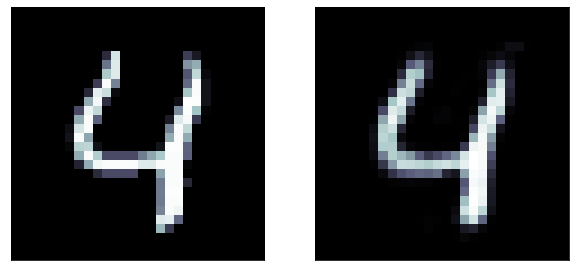

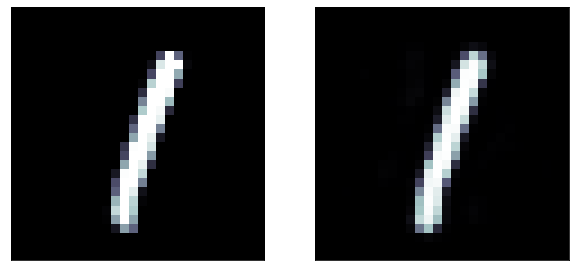

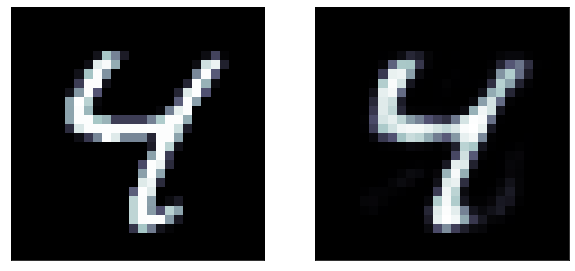

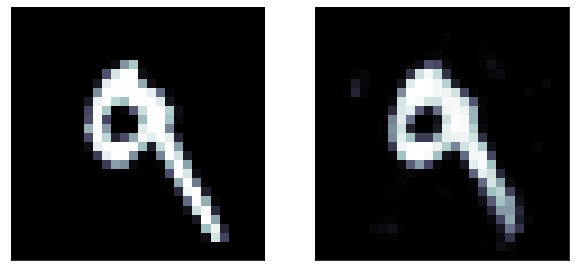

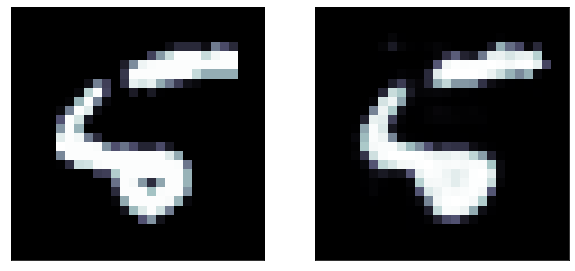

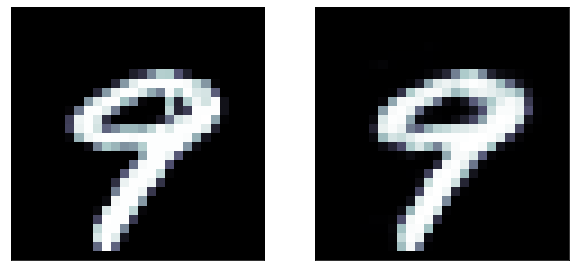

In [ ]:
output_image64_sig = model_digits64_sig.predict(x_test)
for i in range(10):
  compareinout(i, output_image64_sig, x_test)

Much better! Let me choose a loss fuctio that is more appropriate for a nbinary classificaton.

Ogni pixel viene predetto come 0 o 1 a seconda che sia sotto o sopra la soglia di 0.5 e in questo caso la loss del mean squared error non è più molto adatta --> binary cross entropy

Classificatore binario e non lineare

In [ ]:
# sigmoid and binary cross entropy loss
model_digits64_bce = Sequential()
## encoder
# input layer and the output size
model_digits64_bce.add(Dense(units = 128, activation = 'relu', input_dim = ndim))
  #compression layer
model_digits64_bce.add(Dense(units = 64, activation = 'relu'))
## deencoder
#decompression layer, same size as in the encoder
model_digits64_bce.add(Dense(units = 128, activation = 'relu'))
#output layer, same size as input
model_digits64_bce.add(Dense(ndim, activation='sigmoid'))

In [ ]:
model_digits64_bce.compile(keras.optimizers.Adam(lr=0.001), loss="binary_crossentropy")
history64_bce = model_digits64_bce.fit(x_train, x_train, 
                                       validation_data=(x_test, x_test), 
                                       epochs=20, batch_size=100, verbose=1)

Epoch 1/20
600/600 [==============================] - 2s 3ms/step - loss: 0.2463 - val_loss: 0.1117
Epoch 2/20
600/600 [==============================] - 1s 2ms/step - loss: 0.1083 - val_loss: 0.0975
Epoch 3/20
600/600 [==============================] - 1s 2ms/step - loss: 0.0954 - val_loss: 0.0892
Epoch 4/20
600/600 [==============================] - 1s 2ms/step - loss: 0.0896 - val_loss: 0.0856
Epoch 5/20
600/600 [==============================] - 1s 2ms/step - loss: 0.0863 - val_loss: 0.0833
Epoch 6/20
600/600 [==============================] - 1s 2ms/step - loss: 0.0839 - val_loss: 0.0817
Epoch 7/20
600/600 [==============================] - 1s 2ms/step - loss: 0.0820 - val_loss: 0.0801
Epoch 8/20
600/600 [==============================] - 1s 2ms/step - loss: 0.0807 - val_loss: 0.0789
Epoch 9/20
600/600 [==============================] - 1s 2ms/step - loss: 0.0795 - val_loss: 0.0782
Epoch 10/20
600/600 [==============================] - 1s 2ms/step - loss: 0.0788 - val_loss: 0.0774

Text(0.5, 0, 'iteration')

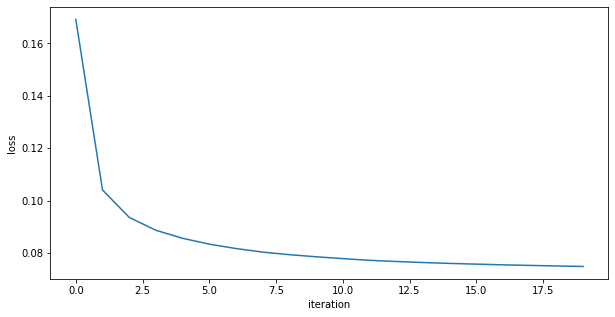

In [ ]:
pl.plot(np.array(history64_bce.history['loss']))
pl.ylabel('loss')
pl.xlabel('iteration')
#pl.yscale('log')
#pl.xscale('log')

This loss fuction is also decreasing to steeply. Too few epochs!

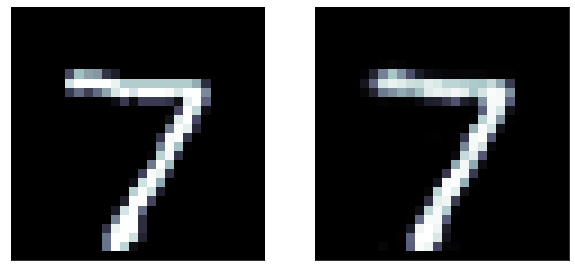

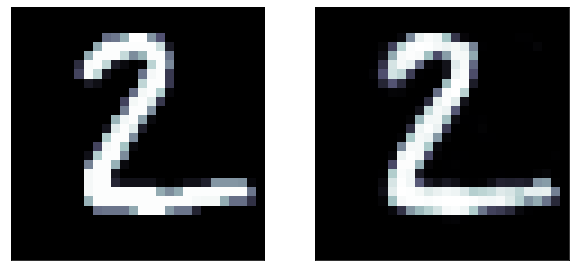

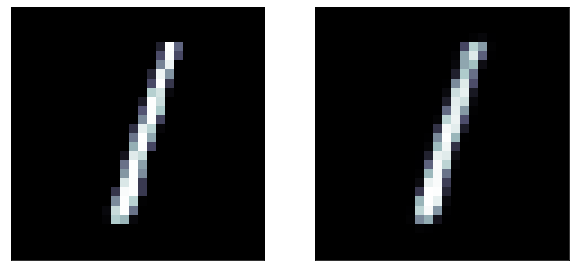

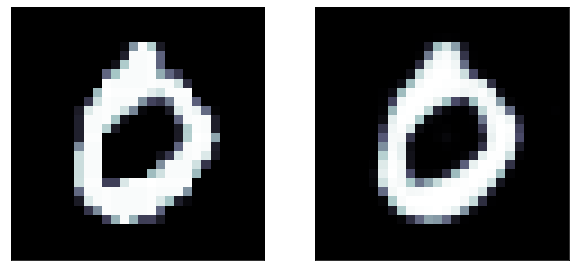

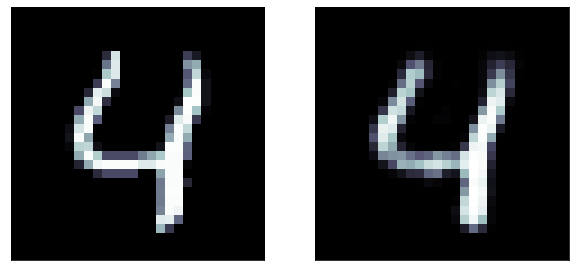

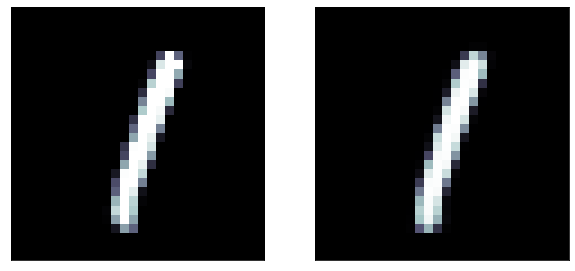

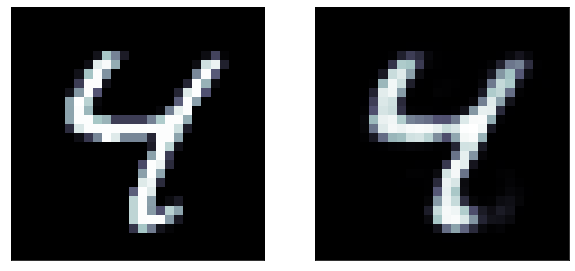

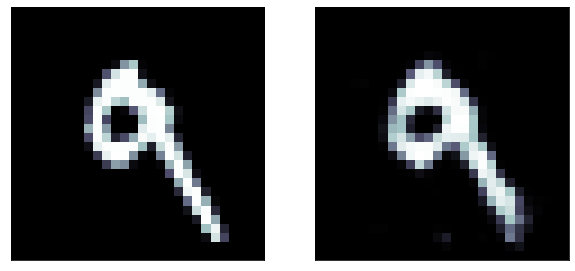

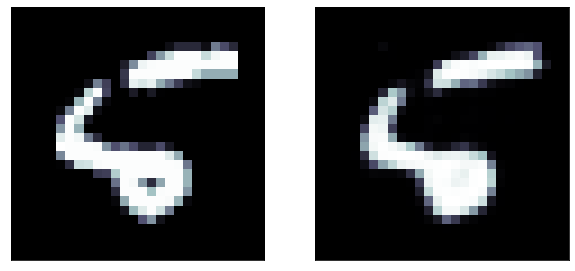

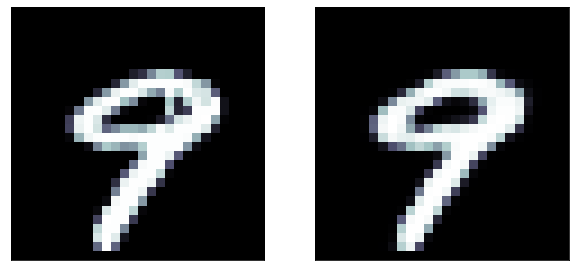

In [ ]:
output_image64_bce = model_digits64_bce.predict(x_test)
for i in range(10):
  compareinout(i, output_image64_bce, x_test)

This is a pretty good result!

Text(0.5, 1.0, 'the 3 loss functions, log scale')

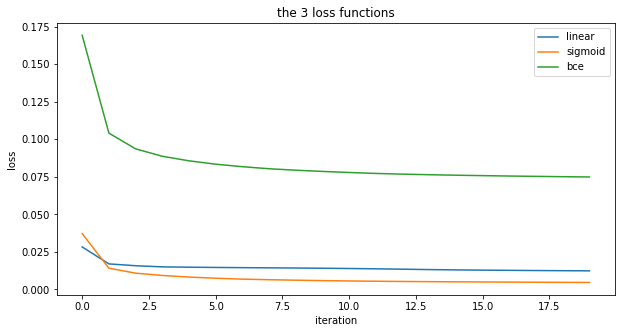

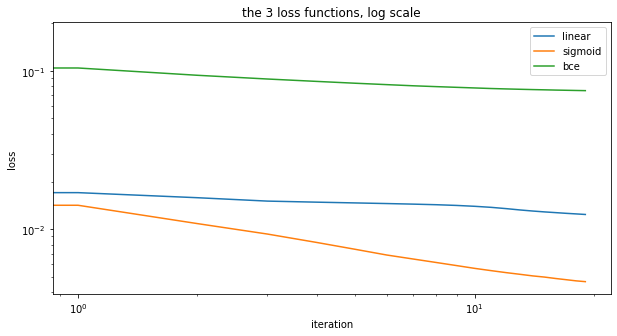

In [ ]:
pl.plot(np.array(history64.history['loss']), label="linear")
pl.plot(np.array(history64_sig.history['loss']), label="sigmoid")
pl.plot(np.array(history64_bce.history['loss']), label="bce")
pl.ylabel('loss')
pl.xlabel('iteration')
pl.legend()
pl.title("the 3 loss functions")
pl.figure()
pl.plot(np.array(history64.history['loss']), label="linear")
pl.plot(np.array(history64_sig.history['loss']), label="sigmoid")
pl.plot(np.array(history64_bce.history['loss']), label="bce")
pl.ylabel('loss')
pl.xlabel('iteration')
pl.xscale('log')
pl.yscale('log')
pl.legend()
pl.title("the 3 loss functions, log scale")

All loss functions plotted: topin natural, bottomin logscale for enhanced visibility. It does not look like any of them is done learning (all decreasing rapidly still), especially the one for the the sigmoid-based mean square error loss.

# try more compression

Now we shrink the bottle neck to 16 neurons: a much more ambitions model!

Ci vuole più tempo per il training ma il risultato sarebbe più utile. Risultato buono sulla classificazione dell'immagine.

In [ ]:
model_digits = Sequential()
## encoder
# input layer and the output size
model_digits.add(Dense(units = 128, activation = 'relu', input_dim = ndim))
model_digits.add(Dense(units = 64, activation = 'relu'))
model_digits.add(Dense(units = 32, activation = 'relu'))
#bottle neck
model_digits.add(Dense(16, activation='relu'))
model_digits.add(Dense(units = 32, activation = 'relu'))
model_digits.add(Dense(units = 64, activation = 'relu'))
model_digits.add(Dense(units = 128, activation = 'relu'))
#decoder
model_digits.add(Dense(ndim, activation='sigmoid'))

In [ ]:
model_digits.compile(keras.optimizers.Adam(lr=0.001), loss="binary_crossentropy")

In [ ]:
print(model_digits.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_14 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_15 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_16 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_17 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_18 (Dense)             (None, 128)              

In [ ]:
history = model_digits.fit(x_train, x_train, epochs=200, batch_size=100, verbose=1)

Epoch 1/200
600/600 [==============================] - 2s 2ms/step - loss: 0.2869
Epoch 2/200
600/600 [==============================] - 1s 2ms/step - loss: 0.1572
Epoch 3/200
600/600 [==============================] - 1s 2ms/step - loss: 0.1420
Epoch 4/200
600/600 [==============================] - 1s 2ms/step - loss: 0.1326
Epoch 5/200
600/600 [==============================] - 1s 2ms/step - loss: 0.1255
Epoch 6/200
600/600 [==============================] - 1s 2ms/step - loss: 0.1214
Epoch 7/200
600/600 [==============================] - 1s 2ms/step - loss: 0.1179
Epoch 8/200
600/600 [==============================] - 1s 2ms/step - loss: 0.1154
Epoch 9/200
600/600 [==============================] - 1s 2ms/step - loss: 0.1132
Epoch 10/200
600/600 [==============================] - 1s 2ms/step - loss: 0.1119
Epoch 11/200
600/600 [==============================] - 1s 2ms/step - loss: 0.1107
Epoch 12/200
600/600 [==============================] - 1s 2ms/step - loss: 0.1090
Epoch 13/200


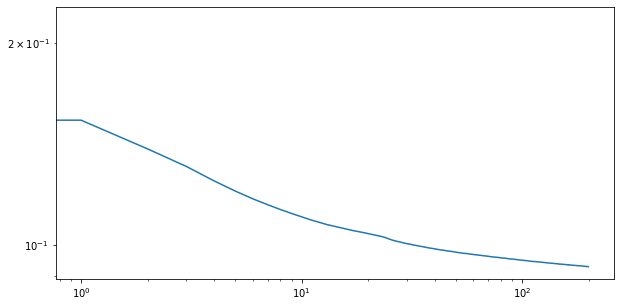

In [ ]:
pl.plot(np.array(history.history['loss']))
pl.yscale('log')
pl.xscale('log')

the loss fuction: once again it did not finish learning. 

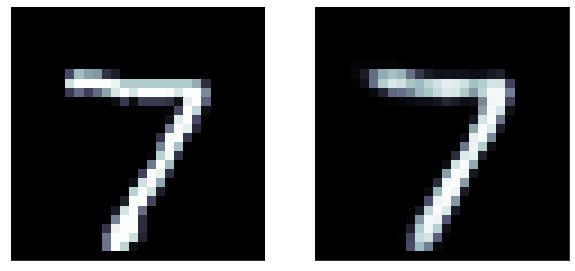

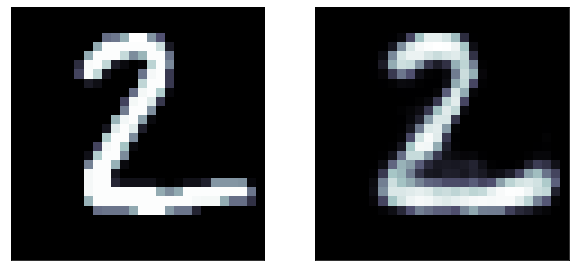

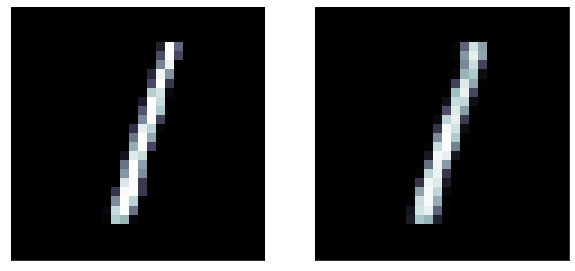

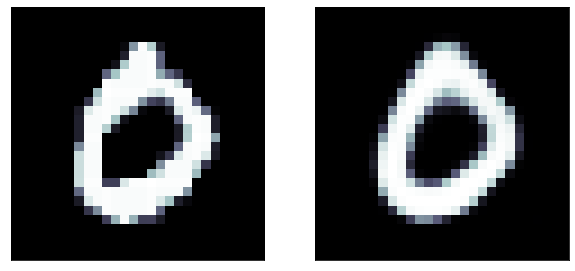

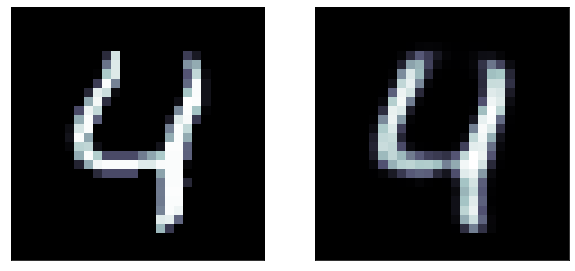

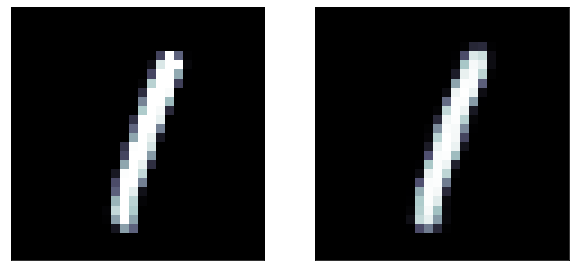

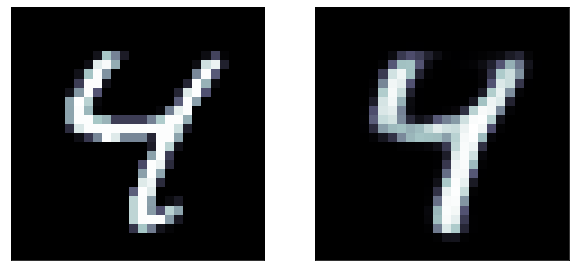

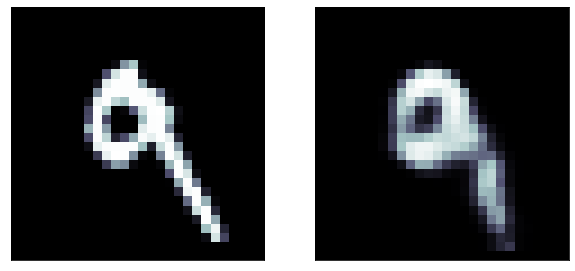

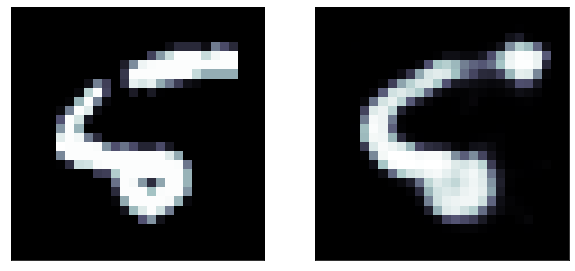

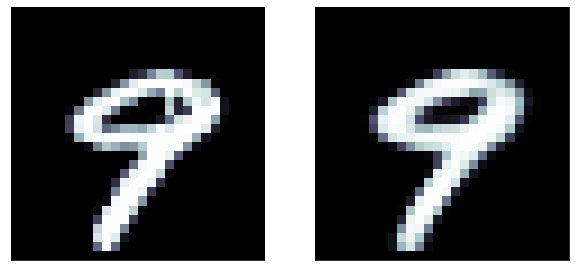

In [ ]:
output_image = model_digits.predict(x_test)

for i in range(10):
  compareinout(i, output_image, x_test)

The result is not bad! The decoder can recreate the image from only 16 numbers!

# Extract feature

Estrazione "a mano" del bottle neck layer

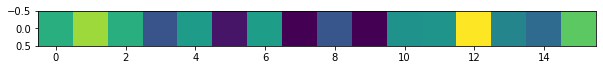

In [ ]:
# estrazione del bottle neck layer
from keras import backend as K
# input placeholder
inp = model_digits.input                   
# extract the bottle neck outputs
outputs = model_digits.layers[3].output # <--     
# create a function to evaluate the output of the bottle neck layer for a given input
functors = K.function([inp], [outputs])    

# Testing
layer_outs = functors(x_test[:1])
pl.imshow(layer_outs[0]);

This is the reducted representation of the first image in the test sample: a 16-values representation of the NxN pixel image

In [ ]:
def compareinout_encoded(i, outim, testimg, initialshape=(28,28)):
  fig = pl.figure(figsize(10,5))
  ax = fig.add_subplot(131) 
  ax.imshow(testimg[i].reshape(initialshape) , cmap="bone")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax = fig.add_subplot(132)
  pl.imshow(functors(testimg[i:i+1])[0])
  pl.yticks([])
  ax = fig.add_subplot(133) 
  ax.imshow(outim[i].reshape(initialshape) , cmap="bone")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)


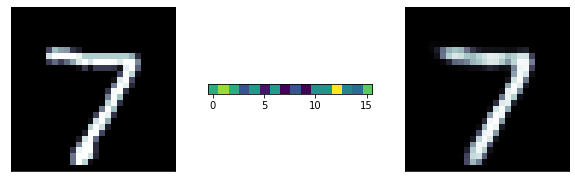

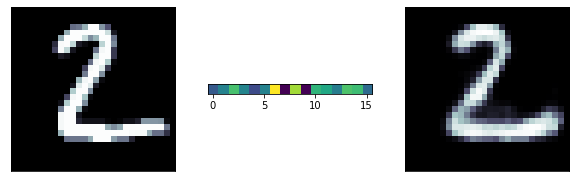

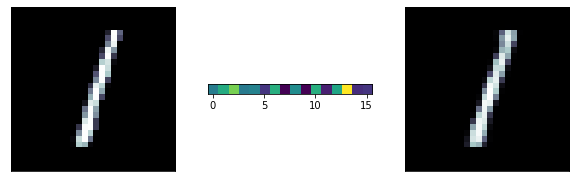

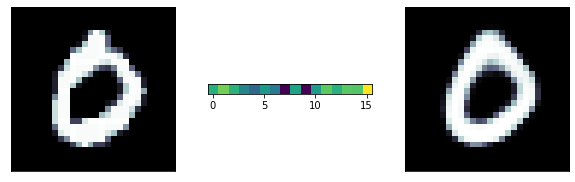

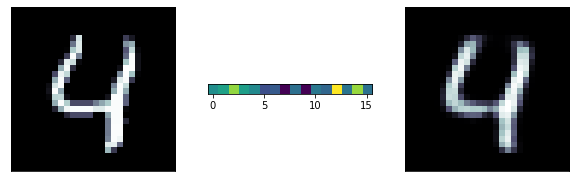

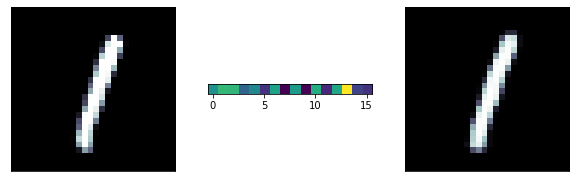

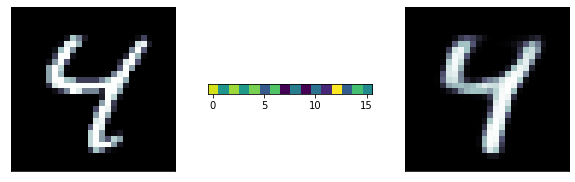

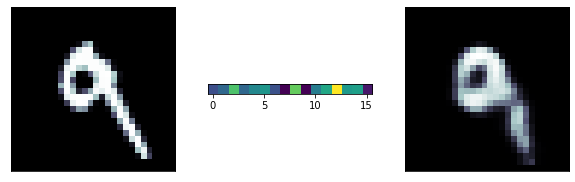

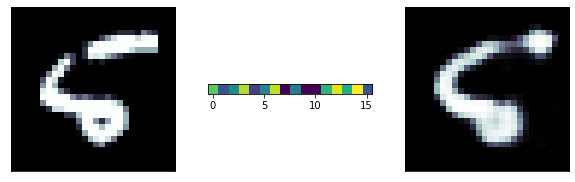

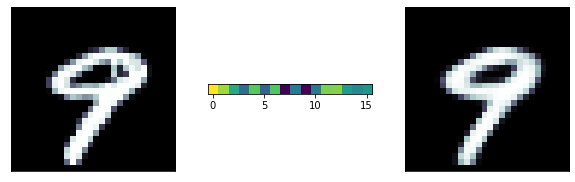

In [ ]:
for i in range(10):
  compareinout_encoded(i, output_image, x_test)

*left*: original image

*center*: compressed representation

right: predicted image